# Using ComBat to remove the batch effects

ComBat is a tool to adjust for batch effects. It uses either parametric or non-parametric empirical Bayes frameworks for adjusting data for batch effects. Users are returned an expression matrix that has been corrected for batch effects. The input data are assumed to be cleaned and normalized before batch effect removal.

Reference:https://academic.oup.com/biostatistics/article/8/1/118/252073

### Loading data and pacakages

In [1]:
import pandas as pd
import numpy as np
import sklearn

import sys
import numpy.linalg as la
import numpy as np
import nibabel as nib
import pandas as pd
#import scipy.io
import patsy
from scipy import stats
%matplotlib inline

In [2]:
def combat(data, batch, model=None, numerical_covariates=None):
    """Correct for batch effects in a dataset

    Parameters
    ----------
    data : pandas.DataFrame
        A (n_features, n_samples) dataframe of the expression or methylation
        data to batch correct
    batch : pandas.Series
        A column corresponding to the batches in the data, with index same as
        the columns that appear in ``data``
    model : patsy.design_info.DesignMatrix, optional
        A model matrix describing metadata on the samples which could be
        causing batch effects. If not provided, then will attempt to coarsely
        correct just from the information provided in ``batch``
    numerical_covariates : list-like
        List of covariates in the model which are numerical, rather than
        categorical

    Returns
    -------
    corrected : pandas.DataFrame
        A (n_features, n_samples) dataframe of the batch-corrected data
    """
    if isinstance(numerical_covariates, str):
        numerical_covariates = [numerical_covariates]
    if numerical_covariates is None:
        numerical_covariates = []

    if model is not None and isinstance(model, pd.DataFrame):
        model["batch"] = list(batch)
    else:
        model = pd.DataFrame({'batch': batch})

    batch_items = model.groupby("batch").groups.items()
    batch_levels = [k for k, v in batch_items]
    batch_info = [v for k, v in batch_items]
    n_batch = len(batch_info)
    n_batches = np.array([len(v) for v in batch_info])
    n_array = float(sum(n_batches))

    # drop intercept
    drop_cols = [cname for cname, inter in  ((model == 1).all()).iteritems() if inter == True]
    drop_idxs = [list(model.columns).index(cdrop) for cdrop in drop_cols]
    model = model[[c for c in model.columns if not c in drop_cols]]
    numerical_covariates = [list(model.columns).index(c) if isinstance(c, str) else c
            for c in numerical_covariates if not c in drop_cols]

    design = design_mat(model, numerical_covariates, batch_levels)

    sys.stdout.write("Standardizing Data across genes.\n")
    B_hat = np.dot(np.dot(la.inv(np.dot(design.T, design)), design.T), data.T)
    grand_mean = np.dot((n_batches / n_array).T, B_hat[:n_batch,:])
    var_pooled = np.dot(((data - np.dot(design, B_hat).T)**2), np.ones((int(n_array), 1)) / int(n_array))

    stand_mean = np.dot(grand_mean.T.reshape((len(grand_mean), 1)), np.ones((1, int(n_array))))
    tmp = np.array(design.copy())
    tmp[:,:n_batch] = 0
    stand_mean  += np.dot(tmp, B_hat).T

    s_data = ((data - stand_mean) / np.dot(np.sqrt(var_pooled), np.ones((1, int(n_array)))))

    sys.stdout.write("Fitting L/S model and finding priors\n")
    batch_design = design[design.columns[:n_batch]]
    gamma_hat = np.dot(np.dot(la.inv(np.dot(batch_design.T, batch_design)), batch_design.T), s_data.T)

    delta_hat = []

    for i, batch_idxs in enumerate(batch_info):
        #batches = [list(model.columns).index(b) for b in batches]
        delta_hat.append(s_data[batch_idxs].var(axis=1))

    gamma_bar = gamma_hat.mean(axis=1) 
    t2 = gamma_hat.var(axis=1)
   

    a_prior = list(map(aprior, delta_hat))
    b_prior = list(map(bprior, delta_hat))

    sys.stdout.write("Finding parametric adjustments\n")
    gamma_star, delta_star = [], []
    for i, batch_idxs in enumerate(batch_info):
        #print '18 20 22 28 29 31 32 33 35 40 46'
        #print batch_info[batch_id]

        temp = it_sol(s_data[batch_idxs], gamma_hat[i],
                     delta_hat[i], gamma_bar[i], t2[i], a_prior[i], b_prior[i])

        gamma_star.append(temp[0])
        delta_star.append(temp[1])

    sys.stdout.write("Adjusting data\n")
    bayesdata = s_data
    gamma_star = np.array(gamma_star)
    delta_star = np.array(delta_star)


    for j, batch_idxs in enumerate(batch_info):

        dsq = np.sqrt(delta_star[j,:])
        dsq = dsq.reshape((len(dsq), 1))
        denom =  np.dot(dsq, np.ones((1, n_batches[j])))
        numer = np.array(bayesdata[batch_idxs] - np.dot(batch_design.loc[batch_idxs], gamma_star).T)

        bayesdata[batch_idxs] = numer / denom
   
    vpsq = np.sqrt(var_pooled).reshape((len(var_pooled), 1))
    bayesdata = bayesdata * np.dot(vpsq, np.ones((1, int(n_array)))) + stand_mean
     
    sys.stdout.write('Output shape: '+ str(bayesdata.shape))    
    
    return bayesdata


def design_mat(mod, numerical_covariates, batch_levels):
    """Generate the design matrix with batch variable the will be fed into the model 

    Parameters
    ----------
    mod : data-matrix
        design matrix for the covariates.
    
    numerical_covariates : list-like
        List of covariates in the model which are numerical, rather than
        categorical
        
    batch_levels : list-like

    Returns
    -------
    design : data-matrix
        final design matrix feed into model
    
    """
    
    design = patsy.dmatrix("~ 0 + C(batch, levels=%s)" % str(batch_levels),
                                                  mod, return_type="dataframe")

    mod = mod.drop(["batch"], axis=1)
    numerical_covariates = list(numerical_covariates)
    sys.stdout.write("found %i batches\n" % design.shape[1])
    other_cols = [c for i, c in enumerate(mod.columns)
                  if not i in numerical_covariates]
    factor_matrix = mod[other_cols]
    design = pd.concat((design, factor_matrix), axis=1)
    if numerical_covariates is not None:
        sys.stdout.write("found %i numerical covariates...\n"
                            % len(numerical_covariates))
        for i, nC in enumerate(numerical_covariates):
            cname = mod.columns[nC]
            #sys.std.write("\t{0}\n".format(cname))
            design[cname] = mod[mod.columns[nC]]
    sys.stdout.write("found %i categorical variables:" % len(other_cols))
    sys.stdout.write("\t" + ", ".join(other_cols) + '\n')
    return design


def it_sol(sdat, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001):
    """Updating g_hat and d_hat until they converged
    Returns
    -------
    adjusted : tuple
        A updated (g_hat, d_hat) tuple.
    """
    n = (1 - np.isnan(sdat)).sum(axis=1)
    g_old = g_hat.copy()
    d_old = d_hat.copy()

    change = 1
    count = 0
    while change > conv:
        #print g_hat.shape, g_bar.shape, t2.shape
        g_new = postmean(g_hat, g_bar, n, d_old, t2)
        sum2 = ((sdat - np.dot(g_new.values.reshape((g_new.shape[0], 1)), np.ones((1, sdat.shape[1])))) ** 2).sum(axis=1)
        d_new = postvar(sum2, n, a, b)
       
        change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())
        g_old = g_new #.copy()
        d_old = d_new #.copy()
        count = count + 1
    adjust = (g_new, d_new)
    return adjust 


def adjust_nums(numerical_covariates, drop_idxs):
    # if we dropped some values, have to adjust those with a larger index.
    if numerical_covariates is None: return drop_idxs
    return [nc - sum(nc < di for di in drop_idxs) for nc in numerical_covariates]

def aprior(gamma_hat):
    m = gamma_hat.mean()
    s2 = gamma_hat.var()
    return (2 * s2 +m**2) / s2


def bprior(gamma_hat):
    m = gamma_hat.mean()
    s2 = gamma_hat.var()
    return (m*s2+m**3)/s2


def postmean(g_hat, g_bar, n, d_star, t2):
    return (t2*n*g_hat+d_star * g_bar) / (t2*n+d_star)


def postvar(sum2, n, a, b):
    return (0.5 * sum2 + b) / (n / 2.0 + a - 1.0)


def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]

In [3]:
demo_data = pd.read_csv('hcp_si_demo.csv', index_col=0)

### Create design matrix

Create design matrix for the variables we want to keep the relationship in the data, like gender, IQ, and other phenotypic variables of interests.

In the demo data, we want to keep age, sex, int, ext, tot.

In [4]:
d_mat = patsy.dmatrix("~ age + sex + int+ ext + tot", demo_data, return_type="dataframe")

### Run ComBat

Keep in mind the input for ComBat needs to be a data matrix has the shape (N_features, N_samples). Don't forget to transpose your data! 

In [5]:
ebat = combat(demo_data.iloc[:, 0:231].transpose(), demo_data['group'], d_mat, numerical_covariates=['age','int','ext','tot'])
after_combat = pd.concat([ebat.transpose(), demo_data.iloc[:, 231:]], axis=1)

found 3 batches
found 4 numerical covariates...
found 1 categorical variables:	sex[T.M]
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting data
Output shape: (231, 1321)

### Show it worked

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
def create_grid(num_rows, num_cols, row_width = 6, space_width = 2):
    """Create subplot grids to custom the space between columns

    Parameters
    ----------
    num_rows : int
        number of rows we want
    num_cols : int
        number of columns we want
    row_width : float
        the width we want the subplot to be
    space_width : float
        the width between everu two columns 
    Returns
    -------
    ax_list : axes-list
    """
    num_sep_rows = lambda x: int((x-1)/2)
    grid = (num_rows,row_width*num_cols + space_width*num_sep_rows(num_cols))

    ax_list = []

    for ind_col in range(num_cols):
        for ind_row in range(num_rows):
            grid_col = row_width*ind_col + space_width*num_sep_rows(ind_col+1)
            grid_row = ind_row

            ax_list += [plt.subplot2grid(grid, (grid_row, grid_col), colspan=row_width)]
    return ax_list

#### i) Plot Pre & Post distribution for the data to have a look

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


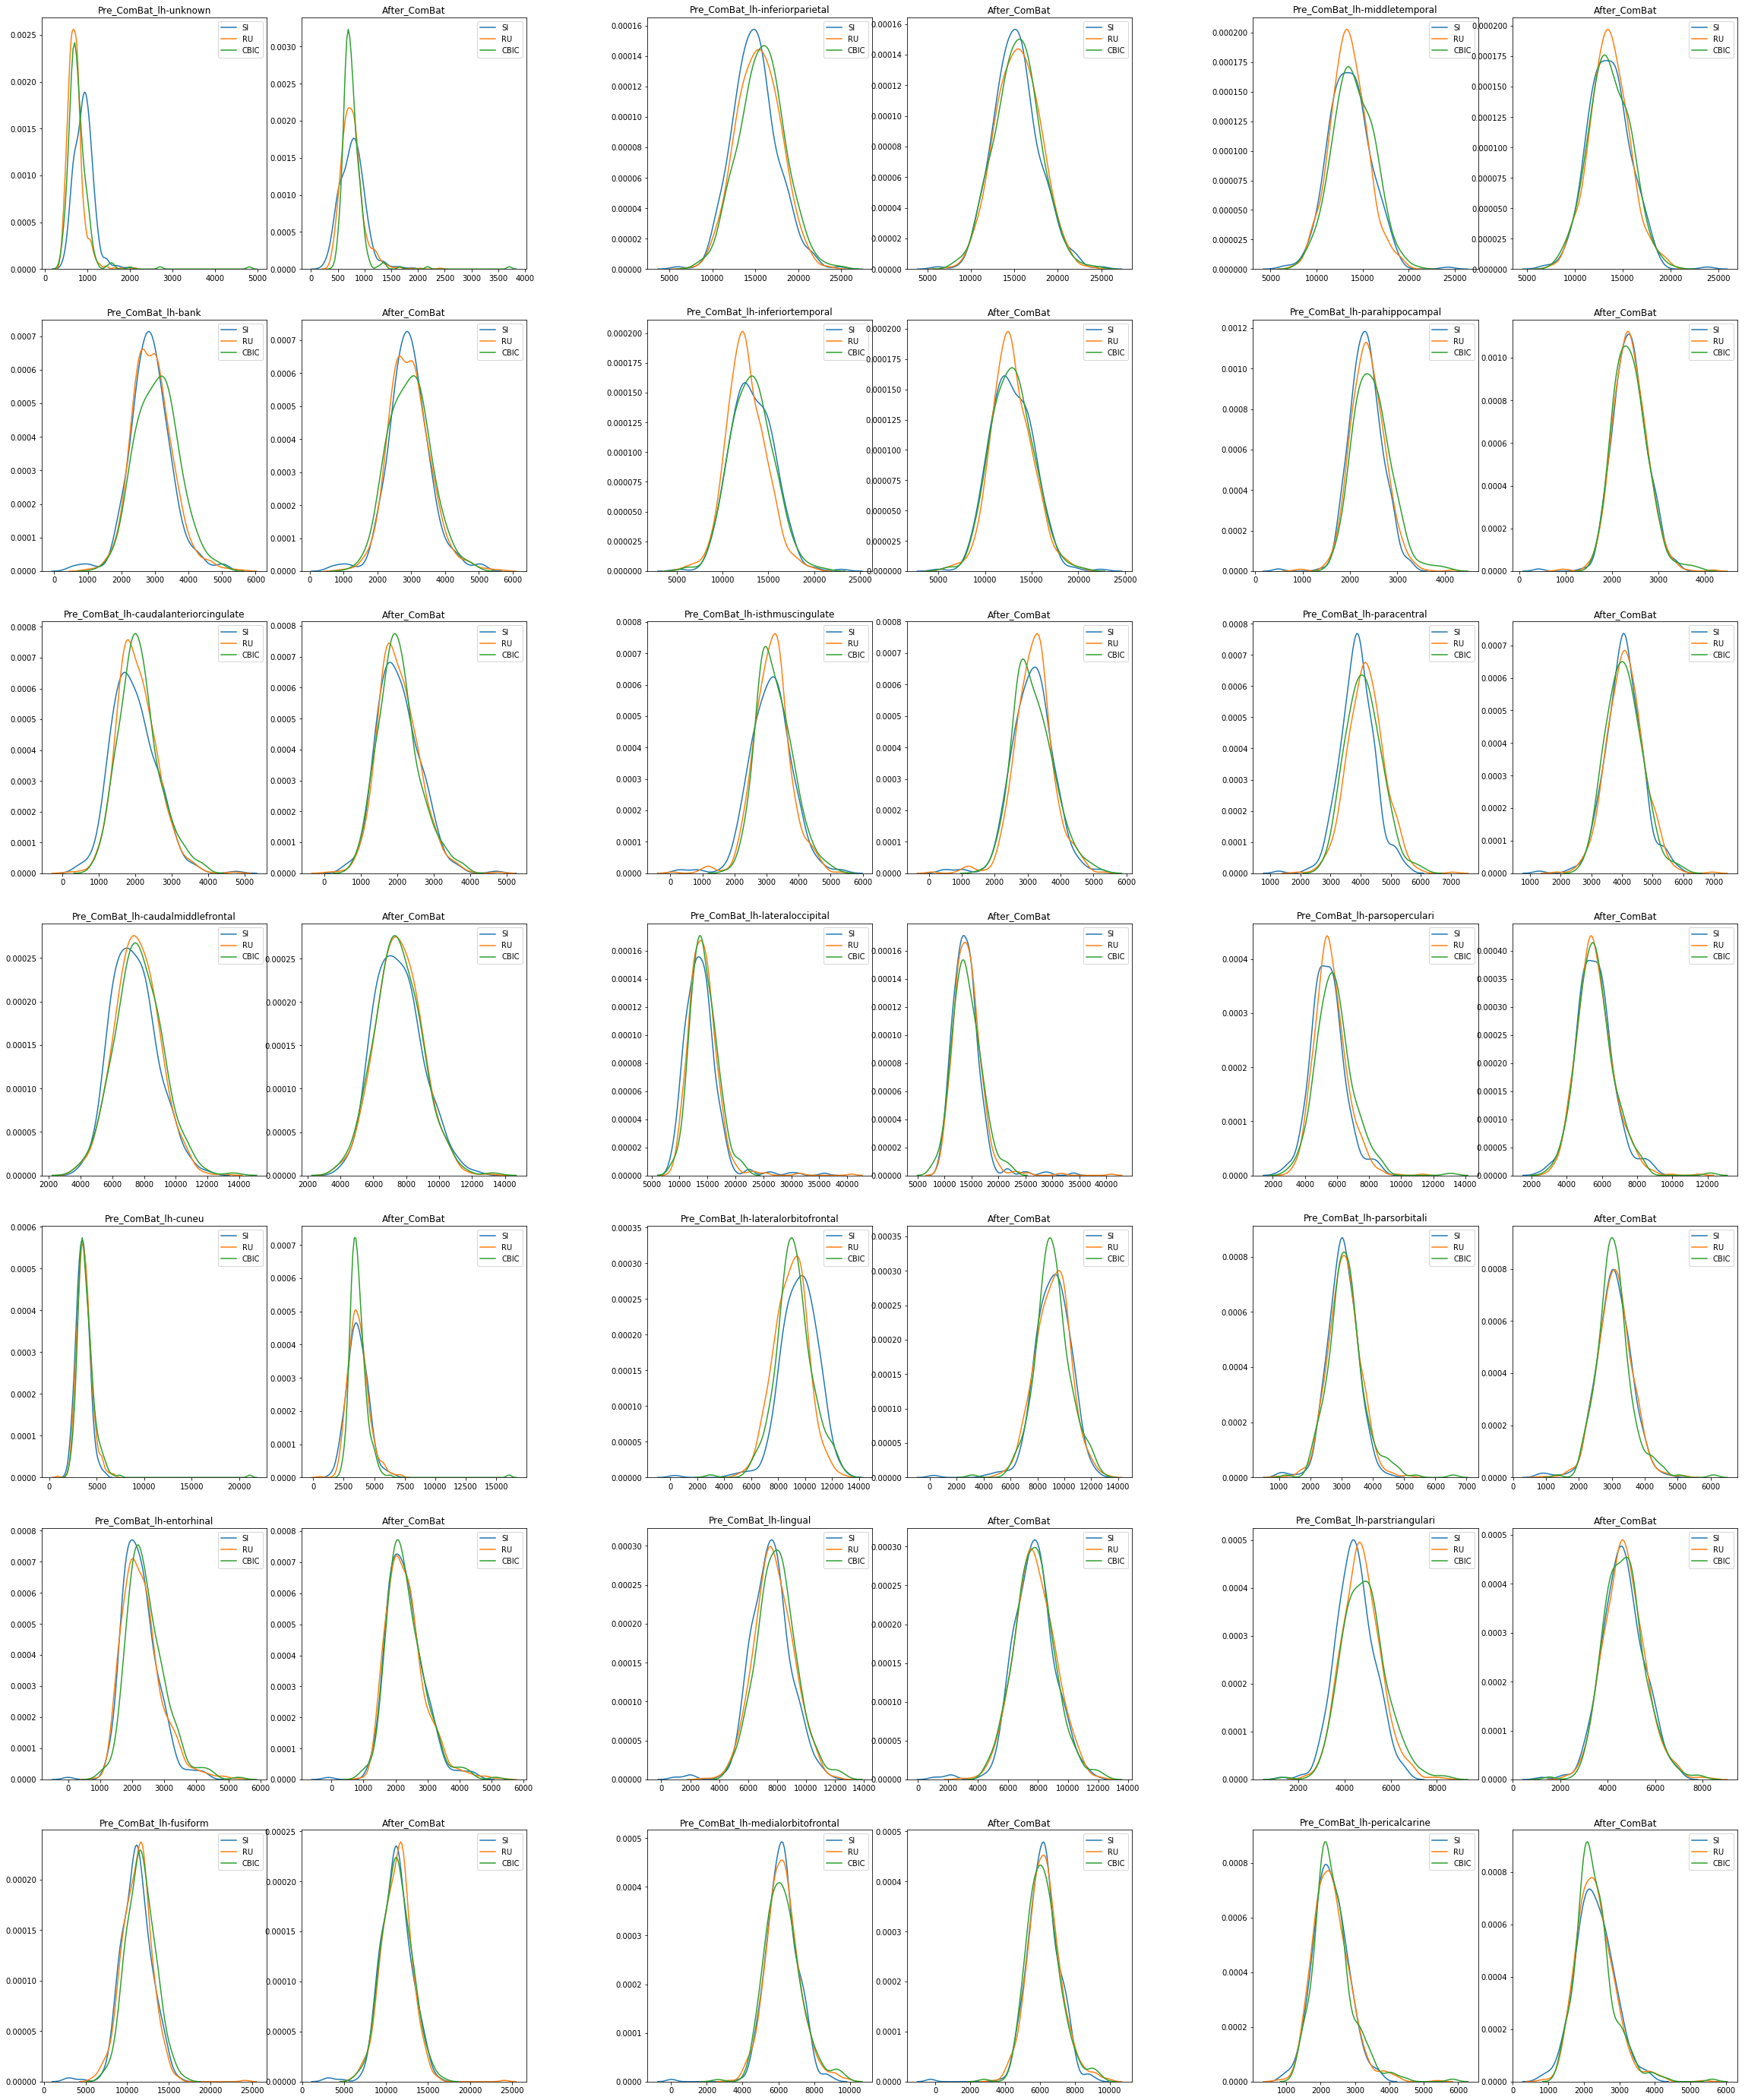

In [8]:
plt.figure(figsize=(40, 50))
ax_list=create_grid(7,6,6,2)
plt.subplots_adjust(wspace=4)

site_list = ['SI', 'RU', 'CBIC']
for i in range(21):
    for j in range(3):
        sns.kdeplot(demo_data.iloc[:,i][demo_data['group']==j], ax=ax_list[int(i/7)*14+i%7], label=site_list[j]).set_title('Pre_ComBat_'+demo_data.columns[i].strip('fs_v_ctx-'))
        sns.kdeplot(after_combat.iloc[:,i][demo_data['group']==j], ax=ax_list[int(i/7)*14+i%7+7], label=site_list[j]).set_title('After_ComBat')

#### ii) Plot Pre & Post P-value distribution 

In this step, run a one-way ANOVA for each variable to see if there is a significant different among different groups.

(0, 1)

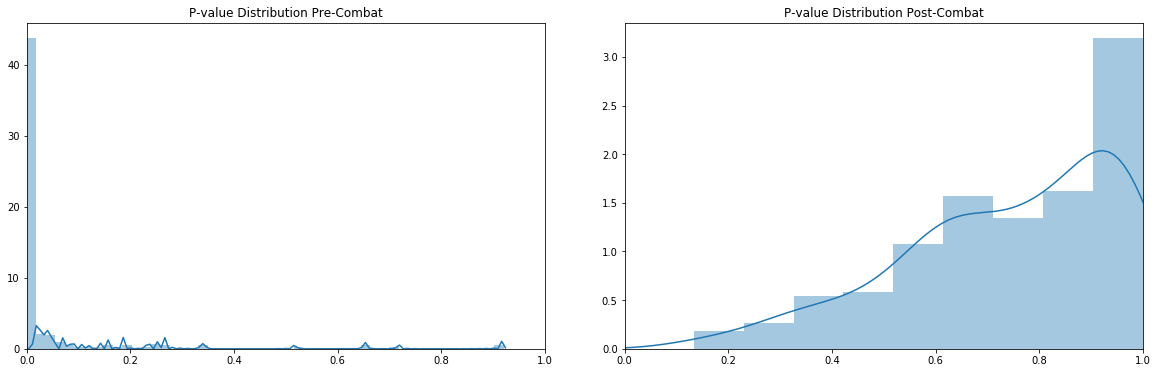

In [9]:
plt.figure(figsize=(20, 6))
ax_list=create_grid(1,2,6,2)
plt.subplots_adjust(wspace=4)

nn=231
p_v = []
for i in range(nn):
    p = stats.f_oneway(demo_data[demo_data.columns[i]][demo_data['group'] == 0], 
         demo_data[demo_data.columns[i]][demo_data['group'] == 1],
         demo_data[demo_data.columns[i]][demo_data['group'] == 2])[1]
    p_v.append(p)

p_v_a = []
for i in range(nn):
    p = stats.f_oneway(after_combat[after_combat.columns[i]][after_combat['group'] == 0], 
         after_combat[after_combat.columns[i]][after_combat['group'] == 1],
         after_combat[after_combat.columns[i]][after_combat['group'] == 2])[1]
    p_v_a.append(p)


sns.distplot(p_v, ax=ax_list[0]).set_title('P-value Distribution Pre-Combat')
ax_list[0].set_xlim([0, 1])



sns.distplot(p_v_a, ax=ax_list[1]).set_title('P-value Distribution Post-Combat')
ax_list[1].set_xlim([0, 1])



In [10]:
#after_combat.to_csv('after_demo.csv')